In [1]:
import sys
import os
import cv2 
import glob
import json
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from scipy.io import loadmat
# from IPython.display import display, Image, HTML
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# train_image_filenames = sorted(glob.iglob('./data/images/train/*.png'))
# for file in train_image_filenames[:1]:
#     print(file)
#     img = cv2.imread(file,0)
#     cv2.imshow('image',img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
def get_attrs(digit_struct_mat_file, index):
    """
    Returns a dictionary which contains keys: label, left, top, width and height, each key has multiple values.
    """
    attrs = {}
    f = digit_struct_mat_file
    item = f['digitStruct']['bbox'][index].item()
    for key in ['label', 'left', 'top', 'width', 'height']:
        attr = f[item][key]
        values = [f[attr.value[i].item()].value[0][0]
                  for i in range(len(attr))] if len(attr) > 1 else [attr.value[0][0]]
        attrs[key] = values
    return attrs

In [3]:

# path_to_digit_struct_mat_file = os.path.join(path_to_dir, 'digitStruct.mat')train_data = loadmat('./data/mat/train_32x32.mat', variable_names='X').get('X')
# train_labels = loadmat('./data/mat/train_32x32.mat', variable_names='y').get('y')
# test_data = loadmat('./data/mat/test_32x32.mat', variable_names='X').get('X')
# test_labels = loadmat('./data/mat/test_32x32.mat', variable_names='y').get('y')
# extra_data = loadmat('./data/mat/extra_32x32.mat', variable_names='X').get('X')
# extra_labels = loadmat('./data/mat/extra_32x32.mat', variable_names='y').get('y')
# print(train_data.shape, train_labels.shape)
# print(test_data.shape, test_labels.shape)
# print(extra_data.shape, extra_labels.shape)

In [4]:
path_to_dir = './train'

In [140]:
path_to_image_file = os.path.join(path_to_dir, '13122.png')
print ("path ", path_to_image_file)
index = int(path_to_image_file.split('/')[-1].split('.')[0]) - 1
print ("index ", index)
with h5py.File('./train/digitStruct.mat', 'r') as digit_struct_mat_file:
    attrs = get_attrs(digit_struct_mat_file, index)
    length = len(attrs['label'])
#     print ("attrs ", attrs)
#     print ("label ", attrs['label'])
#     for i in range(length):
#         print ("label box ", attrs['label'][i], " box ", attrs['left'][i], attrs['top'][i], attrs['width'][i], 
#                attrs['height'][i] )
# #     print ("length", length)
#     print("left, top, width, height", attrs['left'],attrs['top'], attrs['width'], attrs['height'])
    # convert left, top, width, height of image in integer
    attrs_left, attrs_top, attrs_width, attrs_height = map(lambda x: [int(i) for i in x],
                                                       [attrs['left'], attrs['top'], attrs['width'], attrs['height']])
    
    for i in range(length):
        print ("label box ", attrs['label'][i], " box ", attrs_left[i], attrs_top[i], attrs_width[i], 
               attrs_height[i])
    print ("")
#     print ("left, top, width, height", attrs_left, attrs_top, attrs_width, attrs_height)
    min_left, min_top, max_right, max_bottom = (min(attrs_left),
                                                min(attrs_top),
                                                max(map(lambda x, y: x + y, attrs_left, attrs_width)),
                                                max(map(lambda x, y: x + y, attrs_top, attrs_height)))
    
#     for i in range(length):
#         print ("label box ", attrs['label'][i], " Min boxes ", min_left, min_top, max_right, 
#                max_bottom)

    center_x, center_y, max_side = ((min_left + max_right) / 2.0,
                                    (min_top + max_bottom) / 2.0,
                                    max(max_right - min_left, max_bottom - min_top))
    
    bbox_left, bbox_top, bbox_width, bbox_height = (center_x - max_side / 2.0, 
                                                    center_y - max_side / 2.0, 
                                                    max_side,
                                                    max_side)
    
#     print ("box left, box top, box width, height", bbox_left, bbox_top, bbox_width, bbox_height)
    
    cropped_left, cropped_top, cropped_width, cropped_height = (int(round(bbox_left - 0.15 * bbox_width)),
                                                                int(round(bbox_top - 0.15 * bbox_height)),
                                                                int(round(bbox_width * 1.3)),
                                                                int(round(bbox_height * 1.3)))
    print("crop left, crop top, crop width, crop height ", cropped_left, cropped_top, cropped_width, cropped_height)

print ("")
print('min_left=%d, min_top=%d, max_right=%d, max_bottom=%d' % (min_left, min_top, max_right, max_bottom))
print('center_x=%.1f, center_y=%.1f, max_side=%d' % (center_x, center_y, max_side))
print('bbox: left=%.1f, top=%.1f, width=%d, height=%d' % (bbox_left, bbox_top, bbox_width, bbox_height))
# print('cropped: left=%d, top=%d, width=%d, height=%d' % (cropped_left, cropped_top, cropped_width, cropped_height))

path  ./train/13122.png
index  13121
label box  3.0  box  27 4 16 25
label box  3.0  box  43 3 15 25
label box  2.0  box  59 3 16 25

crop left, crop top, crop width, crop height  20 -15 62 62

min_left=27, min_top=3, max_right=75, max_bottom=29
center_x=51.0, center_y=16.0, max_side=48
bbox: left=27.0, top=-8.0, width=48, height=48


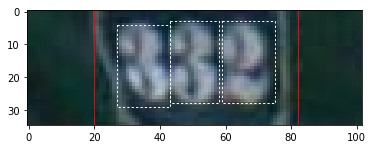

In [141]:
image = Image.open(path_to_image_file)
# image = image.crop((cropped_left, cropped_top, cropped_width+cropped_left, cropped_height+cropped_top))
# image = image[cropped_left:cropped_top,cropped_left, cropped_top]/
# image = image[cropped_top:cropped_height+cropped_top, cropped_left:cropped_left+cropped_width] 

# image = image[12:70+12, 61:61+61]
# plt.show(image)
plt.figure()
currentAxis = plt.gca()
currentAxis.imshow(image)
currentAxis.add_patch(Rectangle((cropped_left, cropped_top), cropped_width, cropped_height, fill=False, edgecolor='red'))
# currentAxis.add_patch(Rectangle((bbox_left, bbox_top), bbox_width, bbox_height, fill=False, edgecolor='black'))
for attr_left, attr_top, attr_width, attr_height in zip(attrs_left, attrs_top, attrs_width, attrs_height):
    currentAxis.add_patch(Rectangle((attr_left, attr_top), attr_width, attr_height, fill=False, edgecolor='white', linestyle='dotted'))
plt.show()

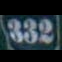

In [142]:
image = Image.open(path_to_image_file)
# image
image.crop((cropped_left, cropped_top, cropped_width+cropped_left, cropped_height+cropped_top))